# 蛋白质和 DNA 结合位点定位

# 成员与分工

+ 张子栋
  + 代码实现 (Java & R部分)
  + 实验报告撰写
  + 模型建立
+ 梁国相
  + 代码校对
  + 数据可视化

# 多重检验问题
$5\%$ 水平的假设检验, 在 $100$ 次假设检验中, 至少出现一次错误(错误地拒绝原假设)的概率为
$$
    1-(1-0.05)^{100}\approx0.994
$$
当一个数据集有多词假设检验时, 需要做多重假设检验校正.

## 控制错误的方法
### $Bonferroni\ Correction$
改变显著性水平 $\alpha = \frac{\alpha}{m}$ 得到新的显著性水平, $reject\ H_i\ if \ p_i\leq \alpha$

> 例如, 如果检验 $1000$ 次, 就将阈值($\frac{\alpha}{m}$) 设定为 $\frac{5\%}{1000}$, 即使检验 $1000$ 次, 出现错误的概率还是保持在 $N\times 1000 = 5\%$
> 该方法虽然简单, 但是检验过于严格, 导致最后找不到显著表达的的蛋白(假阴性)

### False Discovery Rate (FDR)
对于 $m$ 次假设检验 $H_1,H_2,\cdots,H_m$, 得到 P 值: $P_1,P_2,\cdots,P_m$, 将 P 值从小到大进行排序: $P_{(1)},P_{(2)},\cdots,P_{(m)}$
对于给定的 $\overline{\alpha}$, 找到满足条件 $P{(k)}\leq \frac{k}{m}\overline{\alpha}$ 的最大 $k$ 值
然后拒绝 $H_i,i=1,2,\cdots,k$ 这些原假设

> 相对 Bonferroni 来说, FDR 用比较温和的方法对 $p$ 值进行了校正. 其试图在假阳性和假阴性间达到平衡, 将假/真阳性比例控制到一定范围之内, 例如, 如果检验 $1000$ 次, 我们设定的阈值为 $0.05(5\%)$, 那么无论我们得到多少个差异蛋白, 这些差异蛋白出现假阳性的概率保持在 $5\%$ 之内, 这就叫 $FDR＜5\%$.

### 使用 R 中的 `p.adjust()`
`p.adjust(p, method = p.adjust.methods, n = length(p))`
+ `p` 是多重假设检验的多个 `p` 值
+ `p.adjust.methods` 有: 'holm''hochberg''hommel''bonferroni''BH''BY''fdr''none'

# 实验思路
+ 原假设: 读取位点 `reads` 随机落在基因组上.
+ 分布特征: $B(n,p),\ n\to \infty,\ p\to 0$
    + 近似为泊松分布
    + $$P(x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
+ 计算 $P$ 值
    + $P$ 值越小, 越表明测序 `reads` 落在该 DNA 区间不是随机的, 从而说明蛋白质结合具有偏好性.
+ 注意事项
    + 蛋白质跟 DNA 结合位点具有一定范围, 可能不是单个位点
    + DNA `reads` 具有偏好性不天然等价于结合位点
        + 数据除了随机误差, 还可能具有系统偏好性

## 定位峰
分析数据和曲线特征, 寻找局部最大值

1. 阈值筛选峰: 人为设定, 分位数, 拒绝域临界点
2. 局部极大值筛选峰(原始值找顶点, 如以最大值顶点为中心左右各扩展 75 bp)

### 寻找显著峰的方法
1. 使用局部(或全局)泊松分布计算峰中各剪辑的测序深度出现的概率, 并计算局部(或全局)平均测序深度 $\lambda$ (泊松分布均值)对应的概率值作为总体均值(总体理论概率), 然后将峰作为一个样本跟总体均值相比较
2. 根据测序深度作为观察值做一个样本均数假设检验
3. 根据泊松分布直接计算超过这个峰均值的所有观测值之和, 通过这个累计概率是否小于 $0.05$ 判断是否为显著峰

# 实验过程
## 读取数据与可视化

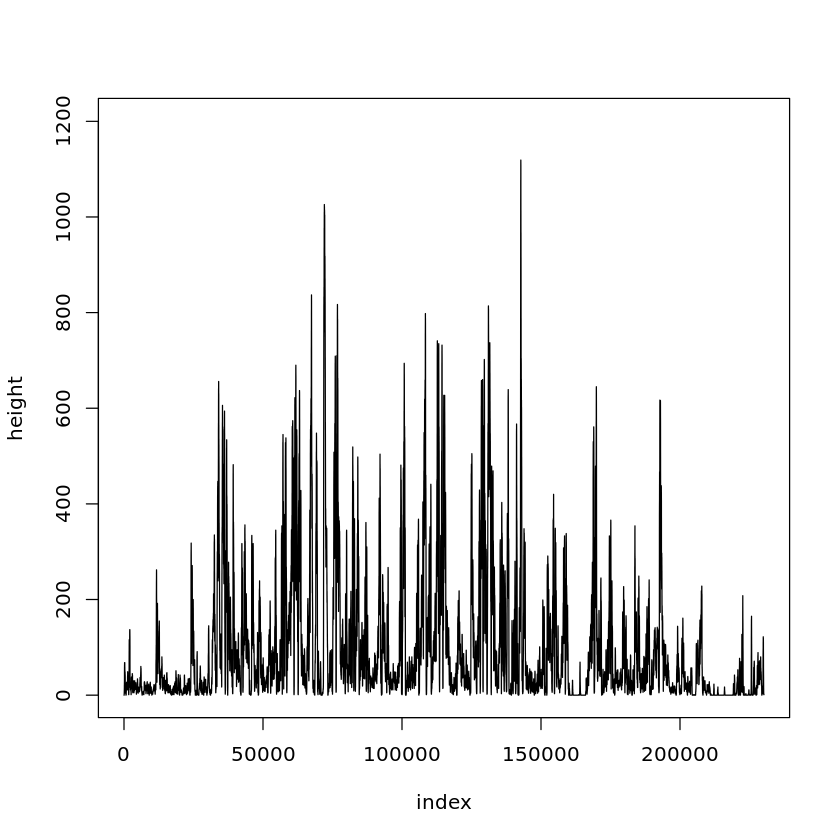

In [5]:
# read data
data <- read.table('GSM1016879_WT_ChrI_K4me3.txt', header = F)
depth <- data[, 4]
pos <- data[, 2]
# visualize
plot(c(1, length(data[, 2])), c(1, 1200), type = "n", xlab = "index", ylab = "height")
lines(pos, depth)

## 获取峰

使用 Java 计算大于均值的极大值, 存入集合 peak 内

```Java
    /**
     * get peak
     *
     * @param allReads all reads
     * @param mean     mean of depth
     * @return peak
     */
    public List<Read> getPeak(List<Read> allReads, int mean) {
        List<Read> peak = new ArrayList<>();
        Read nowRead = null;
        for (int i = 1; i < allReads.size() - 1; i++) {
            nowRead = allReads.get(i);
            if (nowRead.getDepth() >= mean &&
                    nowRead.getDepth() > allReads.get(i - 1).getDepth() &&
                    nowRead.getDepth() > allReads.get(i + 1).getDepth()
            ) {
                peak.add(nowRead);
            }
        }
        return peak;
    }
```
## 扩展 $\pm\ 75 bp$
```Java
    /**
     * expand peak +- 75 bp
     *
     * @param peak peak by max depth
     * @return expanded peaks
     */
    public List<Read> expand(List<Read> allReads, Read peak) {
        List<Read> expandPeak = new ArrayList<>();
        if (peak.getPos() < RATIO) {
            for (int j = 0; j < peak.getPos() + RATIO + 1; j++) {
                expandPeak.add(allReads.get(j));
            }
            return expandPeak;
        } else if (peak.getPos() > 75 && peak.getPos() < READS_NUM - RATIO) {
            for (int j = peak.getPos() - RATIO; j < peak.getPos() + RATIO + 1; j++) {
                expandPeak.add(allReads.get(j));
            }
            return expandPeak;
        } else {
            for (int j = peak.getPos() - RATIO; j < READS_NUM + 1; j++) {
                expandPeak.add(allReads.get(j));
            }
            return expandPeak;
        }
    }
```
+ 导出数据到 R

[1] 5553

[1] 5540


	One Sample t-test

data:  p
t = -166.86, df = 5539, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0.03927716
95 percent confidence interval:
 0.01378857 0.01438054
sample estimates:
 mean of x 
0.01408455 


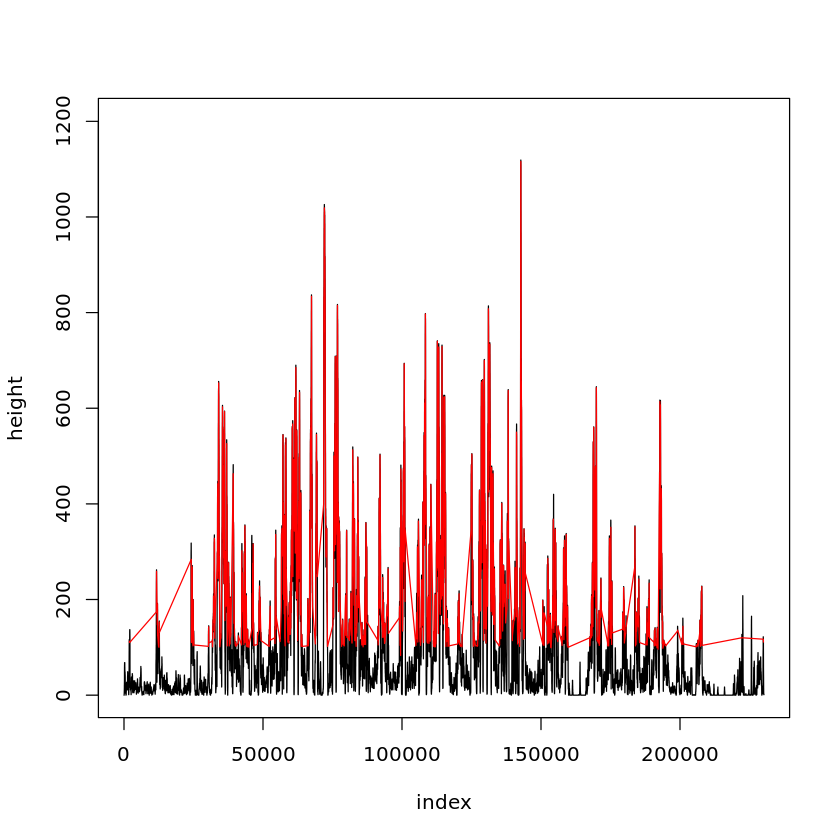

In [37]:
peak <- read.table("poisson.txt", header = T)
peakSection <- read.table("peakSection.txt", header = F)
peakSection <- as.matrix(peakSection)
pValue <- c()
for (i in 1:5553) {
  localP <- c()
  sectionWholeP <- c()
  localP <- c(localP, dpois(peakSection[i,], mean(peakSection[i,])))
  sectionWholeP <- dpois(round(mean(peakSection[i,])), mean(peakSection[i,]))
  pValue <- c(pValue, t.test(x = localP, mu = sectionWholeP)$p.value)
}
pValue <- p.adjust(pValue, method = "fdr")
length(pValue)
length(pValue[pValue < 2.2e-16])
sortedPeak <- peak[which(pValue < 2.2e-16),]
newdepth <- peak[which(pValue < 2.2e-16), 2]
newpos <- peak[which(pValue < 2.2e-16), 1]

# read data
data <- read.table('GSM1016879_WT_ChrI_K4me3.txt', header = F)
depth <- data[, 4]
pos <- data[, 2]
# visualize
plot(c(1, length(data[, 2])), c(1, 1200), type = "n", xlab = "index", ylab = "height")
lines(pos, depth)

lines(newpos, newdepth, col = "red")
p <- dpois(sortedPeak$x, sortedPeak$lambda)
p <- p.adjust(p, method = "fdr")
t.test(p, mu = dpois(103, 103))